adding the imports

In [1]:
import pandas as pd
from scipy.stats import truncnorm
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import expit as activation_function

reading from both datasets and saving them

In [3]:
df = pd.read_csv("fashion-mnist_train.csv")
df2 = pd.read_csv("fashion-mnist_test.csv")

fixing the train dataset so we can run som training code on it

In [4]:
#setting the data as a np.array
data = np.array(df)
#shuffling the data to make it random everytime we train
np.random.shuffle(data)
n_samples,n_features = data.shape
#transpose so we can do dot products and not run into any errors for doing dot product on matrices
data_train = data[0:n_samples].T
Y_train = data_train[0]
#here I did normalisation so we dont get errors when doing dot products
X_train = data_train[1:n_features]/255
#data_train.shape


fixing the test data and normalising it 

In [5]:
data_test = data[0:n_samples].T
Y_test = data_test[0]
#here I did normalisation so we dont get errors when doing dot products
X_test = data_test[1:n_features]/255
#X_test
#data_test.shape

making my helper functions for the training of the neural network

In [6]:
#all of these helper functions were taken from the labs 6 and 7

#relu function
@np.vectorize
def ReLU(x):
    return np.maximum(0,x)

#dderivative of Relu
@np.vectorize
def d_ReLU(x):
    return x > 0

#softmax function
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis = 0)

#sigmoid function
@np.vectorize
#def sigmoid(x):
 #   return 1 / (1 + np.e ** -x)

def sigmoid(x):
    if x < 0:
        return np.exp(x)/(1+np.exp(x))
    else:
        return 1/(1+np.exp(-x))
    
#derivative of sigmoid
@np.vectorize
def d_sigmoid(x):
    return x * (1.0 - x)

#doing a one hot encode function which encodes my Y because I need to normalise it 
#I used this to help me understand it and my other intro to AI module helped me understand this more
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
def one_hot_encode_Y(Y):
    newY = np.zeros ( (Y.size, Y.max() + 1))
    newY[np.arange(Y.size), Y] = 1
    newY = newY.T
    return newY

#this function I created myself for the stopping critera
def difference(arr):
    return [item-arr[i-1] for i, item in enumerate(arr) if i != 0]



creating my neural network class to be able to train my model

In [31]:
#creating a neural network class where I will have all of the training
class neuralNetwork():
    #creating a constructor so we can call objects of this class easier
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        #running the one hot encode fucntion on the y values straight away
        self.newY = one_hot_encode_Y(self.no_of_out_nodes)
    
    #creting the weight matrices so we can have weights for our model
    # I used the value 784 because we have 784 features and 10 for 10 classes 
    def create_weight_matrices(self):
        self.w1 = np.random.rand(10, 784) - 0.5 
        self.b1 = np.random.rand(10, 1) - 0.5
        self.w2 = np.random.rand(10, 10) - 0.5 
        self.b2 = np.random.rand(10, 1) - 0.5
        
        return self.w1, self.b1, self.w2, self.b2
    
    #this is so we get a prediction that I got from the tutorials and changed it a bit
    def get_predictions(self):
        return np.argmax(self.a2, 0)

    #I used this one to calcualted the accuracy of the model for whem we output after every epoch
    def get_accuracy(self,predictions):
        return (np.sum(predictions == self.no_of_out_nodes) / self.no_of_out_nodes.size) * 100
        
    #this is my gradient descent optimzer training model
    def SGDTrain(self, epochs):
        #create the weights and initialise an empty array for the accuracy which we will add to to plot a graph at the end
        self.create_weight_matrices()
        acc_list = []
        #looping the epochs the user gives when calling the function
        for i in range(epochs):
            
            #forward pass with ReLU
            self.z1 = self.w1.dot(self.no_of_in_nodes) + self.b1
            self.a1 = ReLU(self.z1)
            self.z2 = self.w2.dot(self.a1) + self.b2
            self.a2 = softmax(self.z2)
            
            #forard pass with sigmoid
            #self.z1 = self.w1.dot(self.no_of_in_nodes) + self.b1
            #self.a1 = sigmoid(self.z1)
            #self.z2 = self.w2.dot(self.a1) + self.b2
            #self.a2 = softmax(self.z2)
            
            
            #backwards propogation with ReLU
            #I had to run chain rule on the forward propogation to run these calculation and I used the lecutres to help me with this 
            scaling = 1/self.no_of_out_nodes.size    
            self.z2_delta = self.a2 - self.newY
            self.w2_delta = scaling * self.z2_delta.dot(self.a1.T)
            self.b2_delta = scaling * np.sum(self.z2_delta)
            self.z1_delta = self.w2.T.dot(self.z2_delta) * d_ReLU(self.z1)
            self.w1_delta = scaling * self.z1_delta.dot(self.no_of_in_nodes.T)
            self.b1_delta = scaling * np.sum(self.z1_delta)
            
            
            #update weights for gradient descent with the formula 
            #Wnew  = Wold - alpha * [gradient]
            self.w1 -= self.learning_rate * self.w1_delta
            self.b1 -= self.learning_rate * self.b1_delta
            self.w2 -= self.learning_rate * self.w2_delta
            self.b2 -= self.learning_rate * self.b2_delta
            
            #print(self.w1.shape)
            
            #printing this onto the notebook so we can see how good our training is going 
            print(f'epoch: {i+1}') 
            print(f'Accuracy: {(self.get_accuracy(self.get_predictions ())):.2f}%')
            #adding the accuracies after each epoch to the list so we can plot a graph and for the stopping criteria
            acc_list.append(self.get_accuracy(self.get_predictions ()))
            
            #stopping criteria so if accuracy increase 2 times in a row is less than 0.2 it stops training
            diff = difference(acc_list[-3:])
            #checks the last 2 entries in the list and if they are both < 0.2 accuracy change then it stops training
            if len(diff) > 1:
                if(diff[-1] < 0.2 and diff[-2] < 0.2):
                    break
                #debugging my stopping criteria
              #  print(diff[-1])
        return acc_list


training the model

In [32]:
#creating an object of the class neural network with the values as below
model = neuralNetwork(X_train,Y_train, 10 ,0.1)
#callinf the train model with 500 epochs
acc = model.SGDTrain(500)

epoch: 1
Accuracy: 5.90%
epoch: 2
Accuracy: 5.81%
epoch: 3
Accuracy: 6.18%
epoch: 4
Accuracy: 7.69%
epoch: 5
Accuracy: 9.77%
epoch: 6
Accuracy: 12.38%
epoch: 7
Accuracy: 15.30%
epoch: 8
Accuracy: 18.47%
epoch: 9
Accuracy: 21.57%
epoch: 10
Accuracy: 24.18%
epoch: 11
Accuracy: 25.66%
epoch: 12
Accuracy: 26.85%
epoch: 13
Accuracy: 27.95%
epoch: 14
Accuracy: 28.78%
epoch: 15
Accuracy: 29.47%
epoch: 16
Accuracy: 30.17%
epoch: 17
Accuracy: 30.84%
epoch: 18
Accuracy: 31.33%
epoch: 19
Accuracy: 31.96%
epoch: 20
Accuracy: 32.59%
epoch: 21
Accuracy: 33.12%
epoch: 22
Accuracy: 33.65%
epoch: 23
Accuracy: 34.10%
epoch: 24
Accuracy: 34.47%
epoch: 25
Accuracy: 34.84%
epoch: 26
Accuracy: 35.20%
epoch: 27
Accuracy: 35.49%
epoch: 28
Accuracy: 35.91%
epoch: 29
Accuracy: 36.98%
epoch: 30
Accuracy: 37.85%
epoch: 31
Accuracy: 38.61%
epoch: 32
Accuracy: 39.36%
epoch: 33
Accuracy: 40.09%
epoch: 34
Accuracy: 40.66%
epoch: 35
Accuracy: 41.31%
epoch: 36
Accuracy: 41.87%
epoch: 37
Accuracy: 42.38%
epoch: 38
Accur

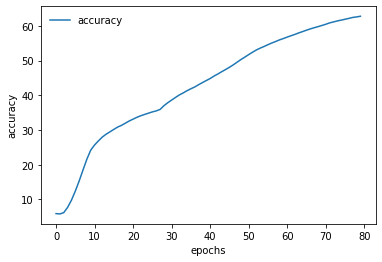

In [33]:

#plotting a graph of epochs by accuracy to see the shape of how well our model is training
plt.plot(acc, label = 'accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(frameon = False)